# Crime Project

In [7]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import fiona
import geopandas
import json

# Google developer API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

ModuleNotFoundError: No module named 'api_keys'

In [23]:
# Store filepath in a variable
shooting_crime_file = "Resources/NYPD_Shooting_Incident_Data__Historic_.csv"

shooting_df = pd.read_csv(shooting_crime_file)
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,25-44,F,BLACK,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045)
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,NaN,<18,F,BLACK,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003)
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006)
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004)
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,NaN,<18,M,BLACK,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025)


In [40]:
boroughs = ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND"]
counties = ["Bronx","Kings","New York","Queens","Richmond"]
population_estimate = [1418207,2559903,1628706,2253858,476143]
gdp_billions = [42695,91559,600244,93310,14514]
gdp_per_capita = [30100,35800,368500,41400,30500]
land_area_miles = [42.10,70.82,22.83,108.53,58.37]
land_area_km = [109.04,183.42,59.13,281.09,151.18]
density_persons_sm = [33867,36147,71341,20767,8157]
density_persons_km = [13006,13957,27544,8018,3150]

nyc_five_boroughs_df = pd.DataFrame({
    "BORO" : boroughs,
    "Counties" : counties,
    "Population Estimate" : population_estimate,
    "GDP Billions" : gdp_billions,
    "GDP Per Capita" : gdp_per_capita,
    "Land Area Miles" : land_area_miles,
    "Land Area Kilometers" : land_area_km,
    "Density Persons Square Miles" : density_persons_sm,
    "Density Persons Kilometers" : density_persons_km
})

nyc_five_boroughs_df

#nyc_shootings_borough_df = pd.merge(shooting_df, nyc_five_boroughs_df, on="BORO")
#nyc_shootings_borough_df.head()

,BORO,Counties,Population Estimate,GDP Billions,GDP Per Capita,Land Area Miles,Land Area Kilometers,Density Persons Square Miles,Density Persons Kilometers
0,BRONX,Bronx,1418207,42695,30100,42.10,109.04,33867,13006
1,BROOKLYN,Kings,2559903,91559,35800,70.82,183.42,36147,13957
2,MANHATTAN,New York,1628706,600244,368500,22.83,59.13,71341,27544
3,QUEENS,Queens,2253858,93310,41400,108.53,281.09,20767,8018
4,STATEN ISLAND,Richmond,476143,14514,30500,58.37,151.18,8157,3150


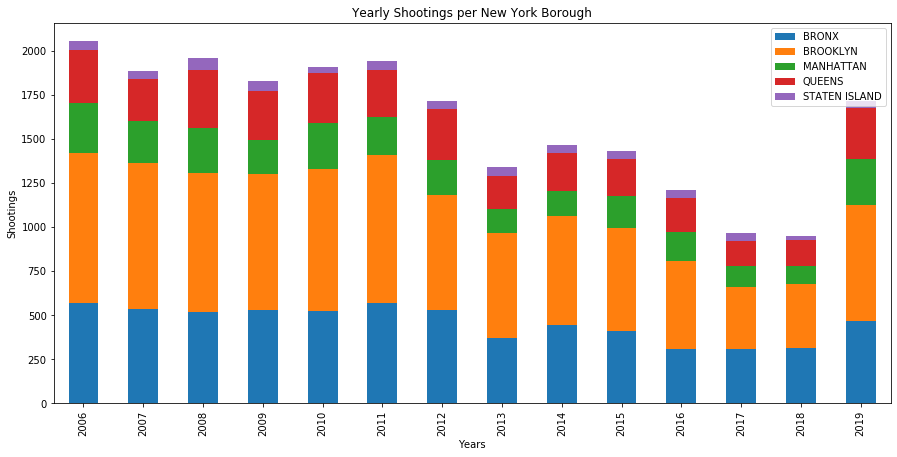

In [54]:
shooting_df["Year"] = pd.DatetimeIndex(shooting_df['OCCUR_DATE']).year

shooting_counts = shooting_df.groupby(["Year","BORO"])["Year"].count().unstack("BORO")

shooting_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")
plt.title("Yearly Shootings per New York Borough")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()

In [ ]:
#Pie of shootings per borough
borough_pie = shooting_counts.BORO.value_counts().plot(kind="pie",autopct='%1.1f%%')

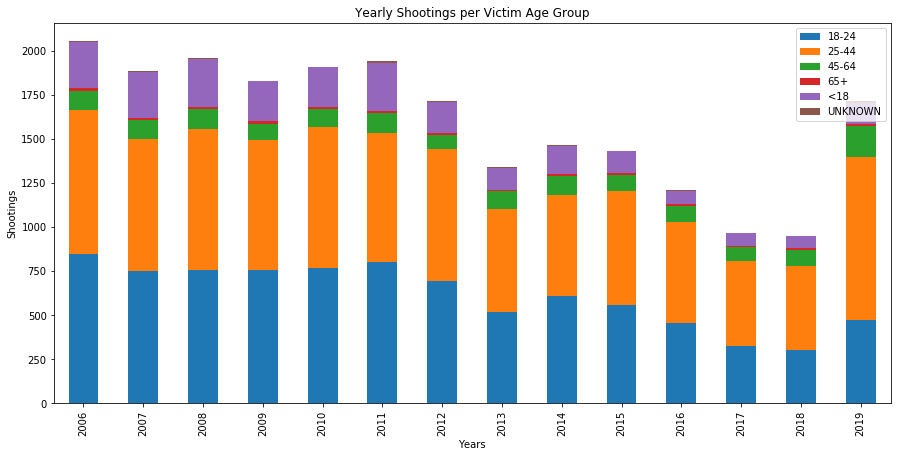

In [26]:
shooting_victim_age_counts = shooting_df.groupby(["Year","VIC_AGE_GROUP"])["Year"].count().unstack("VIC_AGE_GROUP")

shooting_victim_age_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="upper right")

plt.title("Yearly Shootings per Victim Age Group")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()

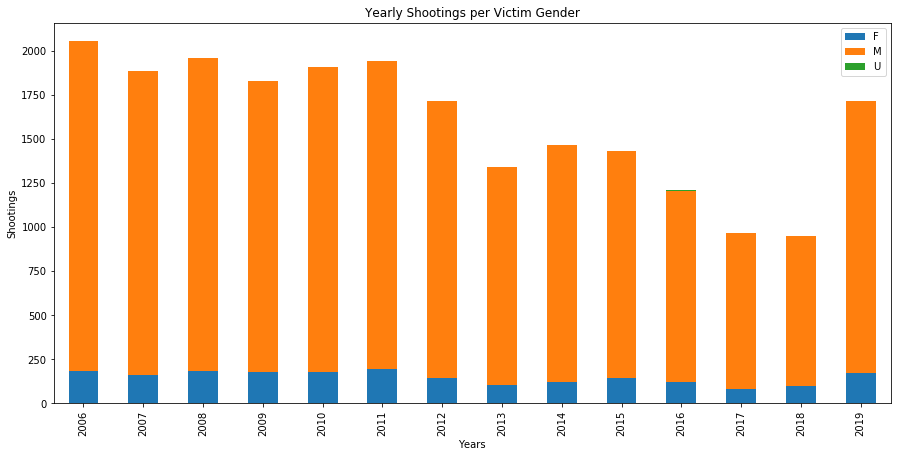

In [27]:
shooting_victim_sex_counts = shooting_df.groupby(["Year","VIC_SEX"])["Year"].count().unstack("VIC_SEX")

shooting_victim_sex_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Gender")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()

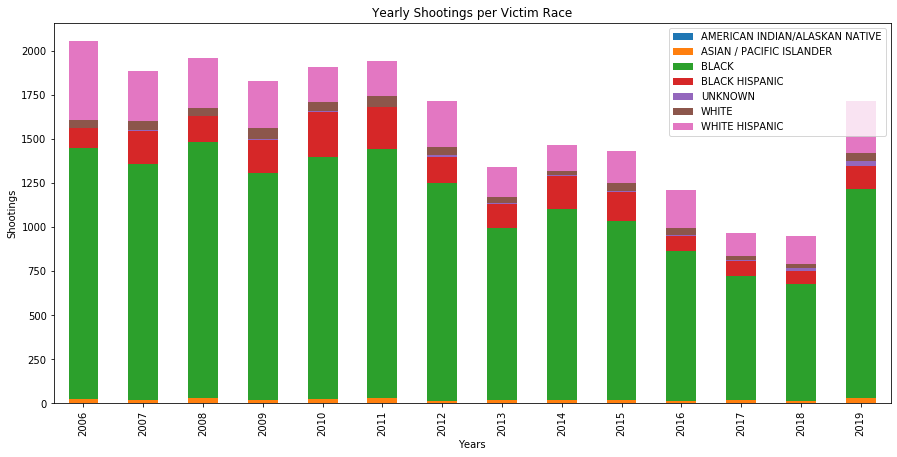

In [28]:
shooting_victim_race_counts = shooting_df.groupby(["Year","VIC_RACE"])["Year"].count().unstack("VIC_RACE")

shooting_victim_race_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Race")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()

In [29]:
# Store latitude and longitude in locations
locations = shooting_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
#weights = shooting_df["Year"].astype(float)

# Plot Heatmap
fig = gmaps.figure(center=(40.7128,-74.0060),zoom_level=10)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations)

# Add layer
fig.add_layer(heat_layer)

gmaps.configure(api_key=g_key)
with open('Resources/Borough Boundaries.geojson') as f:
    geometry = json.load(f)
geojson_layer = gmaps.geojson_layer(geometry, fill_color="white", fill_opacity=0.0, stroke_weight=2)
fig.add_layer(geojson_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [30]:
shooting_df[["TIME_HOUR","TIME_MIN","TIME_SEC"]] = shooting_df['OCCUR_TIME'].str.split(":",expand=True)
shooting_df['TIME_HOUR'] = pd.to_numeric(shooting_df['TIME_HOUR'])

bins = [0,3,7,11,15,19,25]
#labels = ["early morning", "morning/afternoon", "afternoon/evening"]
labels = ["12AM-3:59AM", "4AM-7:59AM", "8AM-11:59AM","12PM-3:59PM","4PM-7:59PM","8PM-11:59PM"]

shooting_df["Time Buckets"] = pd.cut(shooting_df["TIME_HOUR"], bins, labels=labels, include_lowest=True)
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Year,TIME_HOUR,TIME_MIN,TIME_SEC,Time Buckets
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,...,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045),2016,20,36,00,8PM-11:59PM
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,...,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003),2015,1,30,00,12AM-3:59AM
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,...,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006),2014,22,39,00,8PM-11:59PM
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,...,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004),2016,1,30,00,12AM-3:59AM
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,...,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025),2007,23,30,00,8PM-11:59PM


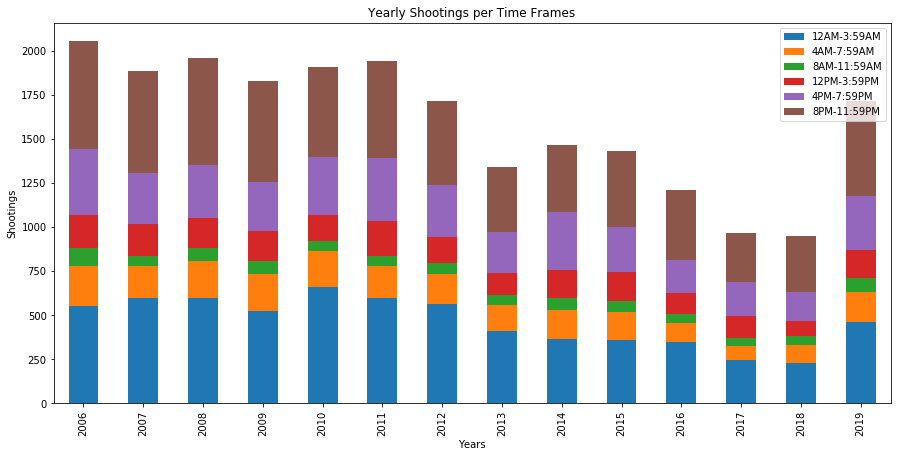

In [31]:
shooting_time_counts = shooting_df.groupby(["Year","Time Buckets"])["Year"].count().unstack("Time Buckets")

shooting_time_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")

plt.title("Yearly Shootings per Time Frames")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()

In [34]:
murders_df = shooting_df.loc[shooting_df["STATISTICAL_MURDER_FLAG"] == True, :]
murders_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Year,TIME_HOUR,TIME_MIN,TIME_SEC,Time Buckets
6,73325412,06/22/2010,0:39:00,BROOKLYN,75,0.0,NaN,True,NaN,NaN,...,1015269,182675,40.668031,-73.888186,POINT (-73.88818647399995 40.66803128600003),2010,0,39,00,12AM-3:59AM
11,78452336,04/27/2011,21:19:00,BRONX,52,0.0,NaN,True,NaN,NaN,...,1011456,255094,40.866815,-73.901638,POINT (-73.90163815599993 40.866815014000046),2011,21,19,00,8PM-11:59PM
17,52078122,10/09/2008,12:45:00,BROOKLYN,81,0.0,NaN,True,NaN,NaN,...,1004426,187539,40.681413,-73.927258,POINT (-73.92725792699997 40.681413218000046),2008,12,45,00,12PM-3:59PM
23,163842829,04/16/2017,21:45:00,BRONX,44,0.0,NaN,True,25-44,M,...,1008325,246288,40.842654,-73.912990,POINT (-73.91298990299998 40.84265427100007),2017,21,45,00,8PM-11:59PM
24,81182107,10/13/2011,15:36:00,BROOKLYN,75,0.0,GAS STATION,True,NaN,NaN,...,1016008,185359,40.675396,-73.885510,POINT (-73.88550993999998 40.67539564000003),2011,15,36,00,12PM-3:59PM


C:\Users\melodie.staton\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


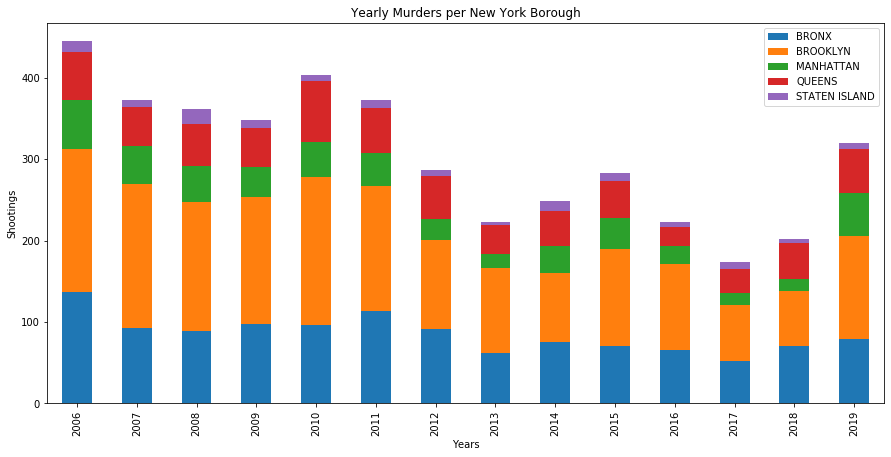

In [35]:
murders_df["Year"] = pd.DatetimeIndex(murders_df['OCCUR_DATE']).year

murder_counts = murders_df.groupby(["Year","BORO"])["Year"].count().unstack("BORO")

murder_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")
plt.title("Yearly Murders per New York Borough")
plt.xlabel("Years")
plt.ylabel("Shootings")
plt.show()